In [35]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
import unidecode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
import nltk
import string
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer

In [36]:
def replace_par_regex(tex:str, langue='francais') ->str :
    
    """
    mets les caractères en minuscule
    supprime les caractères non alphabétiques
    """

    # mettre le texte en minuscule
    pe = tex.lower()


    if langue == 'english':
        pe = re.sub('[^a-z_]','_',pe)
    else:
        pe = re.sub('[^a-zàâçéèêëîïôûùüÿñæœ]', '_', pe)
    
    # supprimer les mots de 1 ou deux lettres
    pe = re.sub('_[a-zàâçéèêëîïôûùüÿñæœ]{1,2}_', '_',pe)

    pe = re.sub('[_]{2,}','_',pe)
    pe = re.sub('_',' ',pe)
    
    # supprimer le l qui reste parfois
    pe = re.sub(' l ',' ', pe)

    return pe



def afficher_nuage_mots(var:str, nombre_de_mots:int, langage='francais', *args):

    """
    affiche un nuage de mots les plus importants dans un texte
    prend en variables une chaîne de caractère, le nombre de mots importants à afficher, la langue, un tuple d'éventuels mots à ajouter au stopwords
    """


    if langage == 'english':
        SW = stopwords.words('english')
    else:
        SW = stopwords.words('french')
    

    if args:
        for el in args:
            SW.append(el)

    
    WC = WordCloud(background_color = 'white', stopwords = SW, max_words = nombre_de_mots).generate(var)
    plt.imshow(WC)
    plt.axis("off")
    plt.show()






def lemm_stem(dataset, type='stem'):
    
    """
    lemmization ou stemming d'un dataset
    pour la lemmization, nécessité d'enlever les accents 
    retourne le dataset traité
    """



    french_stopwords = nltk.corpus.stopwords.words('french')
    lemmatizer = FrenchLefffLemmatizer()
    wnl = WordNetLemmatizer() 
    stemmer = SnowballStemmer(language='french')



    if type =='lemm':

        for i in range(dataset.shape[0]):

            st = ""    
            var = unidecode.unidecode(dataset.iloc[i])
            tokenize_sentence = nltk.tokenize.word_tokenize(var)   
            words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]    
            words_lemmatize = [wnl.lemmatize(w) for w in words_w_stopwords] 
            for j in range(len(words_lemmatize)):
                st = st + ' ' + words_lemmatize[j] + ' '
            dataset.iloc[i] = st
        
        return dataset


    if type =='stem':

        for i in range(dataset.shape[0]):

            st = ""
            tokenize_sentence = nltk.tokenize.word_tokenize(dataset.iloc[i])
            words_w_stopwords = [i for i in tokenize_sentence if i not in french_stopwords]
            words_stemming = [stemmer.stem(w) for w in words_w_stopwords]
            for j in range(len(words_stemming)):
                st = st + ' ' + words_stemming[j] + ' '
            dataset.iloc[i] = st

        return dataset


def sac_de_mots(dataframe, sac):
    
    """
    ne garder que les mots du sacs de mots
    """

    for i in range(dataframe.shape[0]):


        liste = np.array(dataframe.iloc[i].split(' '))
        bag = np.array(sac)

        res = np.intersect1d(bag, liste) 
    
        stri = ""

        for occ in list(res):

            stri = stri + ' ' + occ

        dataframe.iloc[i] = stri



def intersection(datafram, sac):
    
    
    dataframe = datafram.copy()
    
    for i in range(10):

        phra = np.array(dataframe.iloc[i].split())

        phra = np.intersect1d(phra, sac)
    
        st = ""
        for j in range(phra.shape[0]):
            st = st + " " + phra[j]

        dataframe.iloc[i] = st 

    return dataframe

## récupérer les données

In [37]:
data = pd.read_csv('data.csv')

In [38]:
variable = data['commentaire'] 
target = data['note']

X_train_test, X_val, y_train_test, y_val = train_test_split(variable, target, test_size = 0.1, stratify = target)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size = 0.2, stratify = y_train_test)

In [39]:
print(f'{variable.shape[0]:-<10}nombre de variables totales')
print(f'{X_train.shape[0]:-<10}nombre de variables du jeu d\'entraînement')
print(f'{X_test.shape[0]:-<10}nombre de variables du jeu de test')
print(f'{X_val.shape[0]:-<10}nombre de variables du jeu de validation')

29768-----nombre de variables totales
21432-----nombre de variables du jeu d'entraînement
5359------nombre de variables du jeu de test
2977------nombre de variables du jeu de validation


## Visualisation et récupération des nuages de mots

In [40]:
# lemmatization des jeux de données
X_train_lemm = lemm_stem(X_train, type='lemm')

X_test_lemm = lemm_stem(X_test, type='lemm')

X_val_lemm = lemm_stem(X_val, type='lemm')

In [41]:
stb = ""

for i in range(X_train_lemm.shape[0]):

    stb = stb + " " + X_train_lemm.iloc[i] + " "

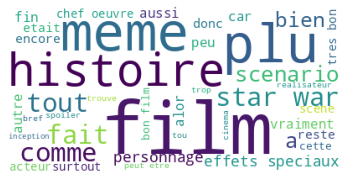

In [14]:
# sac de mots avec lemmiztion
afficher_nuage_mots(stb, nombre_de_mots=40)

In [42]:
# récupérer les mots importants par sacs de mots

nombre_mots2 = 500

sac_de_mots_lemm = WordCloud(background_color = 'white', stopwords = stopwords.words('french'), max_words = nombre_mots2).generate(stb).words_

sac_de_mots_lemm = list(sac_de_mots_lemm.keys())

In [43]:
X_train_lemm = intersection(X_train_lemm, sac_de_mots_lemm)
X_test_lemm = intersection(X_test_lemm, sac_de_mots_lemm)
X_val_lemm = intersection(X_val_lemm, sac_de_mots_lemm)

---------------------------------

In [44]:
cvec = CountVectorizer()

In [45]:
cvec.fit(sac_de_mots_lemm)

CountVectorizer()

In [46]:
X_train = pd.DataFrame(cvec.transform(X_train_lemm).todense().tolist())

In [47]:
X_test = pd.DataFrame(cvec.transform(X_test_lemm).todense().tolist())

In [48]:
X_val = pd.DataFrame(cvec.transform(X_val_lemm).todense().tolist())

In [49]:
clf = LogisticRegression(max_iter=1000)

In [50]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [51]:
clf.score(X_train, y_train)

0.8321668533034714

In [52]:
clf.score(X_test, y_test)

0.8249673446538534

In [53]:
clf.score(X_val, y_val)

0.824319785018475

<AxesSubplot:>

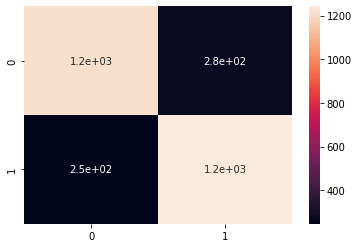

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

mat = confusion_matrix(y_val, clf.predict(X_val) )

sb.heatmap(mat, annot=True)
